In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

import tensorflow as tf
# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

In [2]:
import glob
uav_path = '../data/22050/loaded/*.*'
loaded_path = '../data/22050/unloaded/*.*'
none_path = '../data/22050/none/*.*'

uav_files = glob.glob(uav_path)
loaded_files = glob.glob(loaded_path)
none_files = glob.glob(none_path)

In [3]:
print(len(uav_files),'개\t', uav_files[0])
print(len(uav_files),'개\t', loaded_files[0])
print(len(none_files), '개\t',none_files[0])

10 개	 ../data/22050/loaded\LGgram_P2_loaded bck and forth.wav
10 개	 ../data/22050/unloaded\LGgram_P2_unloaded back forth.wav
25 개	 ../data/22050/none\background_06_02_01.WAV


# Load Data

The reason of why SR is 44100 is that the sample rate of above files is 44.1kbps

a wav file sample has 884736. if sample is divided by sample rate, the value is time
the time is fixed by 20.06

In [4]:
def load(files, sr=22050):
    [raw, sr] = librosa.load(files[0], sr=sr)
    for f in files[1:]:
        [array, sr] = librosa.load(f, sr=sr)
        raw = np.hstack((raw, array))
    print(raw.shape)
    return raw

In [5]:
uav_raw = load(uav_files)
loaded_raw = load(loaded_files)
none_raw = load(none_files)

(14077547,)
(23781589,)
(10960896,)


# Feature extraction 
## steps
#### 1. Resampling 
#### 2. *VAD*( Voice Activity Detection)
#### 3. Maybe padding with 0 to make signals be equal length
#### 4. Log spectrogram (or *MFCC*, or *PLP*)
#### 5. Features normalization with *mean* and *std*
#### 6. Stacking of a given number of frames to get temporal information



## 1. Resampling

if you see the graph, there are few at high frequency. this is mean that data is big but it's no useless. so To small the data, do Resampling. In general, use 0~8000Hz 

## 2. VAD

Sometimes, Files have silence. It is not necessary. So, We need to find sound of Drone except silence.

But, Not yet implemented

## 3. padding with 0 to make signals be equal length

If we have a lot of sound files, we need to pad some datas. But These files's time is longger than 1 second. So It dosn't need to pad

## 4. Log spectrogram (or MFCC, or PLP)

The upper picture is resampled data. 
The lower picture is original data.

In MFCC Feature, There is no big difference. 

In [6]:
from scipy.stats import skew
#returns mfcc features with mean and standard deviation along time
def mfcc4(raw, label, chunk_size=8192, window_size=4096, sr=22050, n_mfcc=16, n_frame=16):
    mfcc = np.empty((0, n_mfcc* n_frame))
    y = []
    print(raw.shape)
    for i in range(0, len(raw), chunk_size//2):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc) #n_mfcc,17
        if mfcc_slice.shape[1] < 17:
            print("small end:", mfcc_slice.shape)
            continue
        mfcc_slice = mfcc_slice[:,:-1]
        #print(mfcc_slice.shape)
        mfcc_slice = mfcc_slice.reshape((1, mfcc_slice.shape[0]* mfcc_slice.shape[1]))
        #print(mfcc_slice.shape)
        mfcc = np.vstack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)
def mfcc(raw, chunk_size=8192, sr=22050, n_mfcc=13):
    mfcc = np.empty((13, 0))
    for i in range(0, len(raw), chunk_size):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc)
        mfcc = np.hstack((mfcc, mfcc_slice))
    return mfcc

In [38]:
'''
mfcc_uav, y_uav = mfcc4(uav_raw, 1)
print(mfcc_uav.shape, y_uav.shape)
mfcc_none, y_none = mfcc4(none_raw, 0)
print(mfcc_none.shape, y_none.shape)
'''
mfcc_uav = mfcc(uav_raw)
mfcc_loaded = mfcc(loaded_raw)
mfcc_none = mfcc(none_raw)
print(len(mfcc_uav),len(mfcc_loaded),len(mfcc_none) )

13 13 13


## 5. Features normalization with *mean* and *std*

## 6. Stacking of a given number of frames to get temporal information

In [39]:
# or should we give one label to one chunk?
y_uav = np.ones(mfcc_uav.shape[1], dtype=int)*2
y_loaded = np.ones(mfcc_loaded.shape[1], dtype=int)
y_none =np.zeros(mfcc_none.shape[1], dtype=int)

print(y_uav.shape, y_uav[0])
print(y_loaded.shape, y_loaded[0])
print(y_none.shape, y_none[0])

X = np.hstack((mfcc_uav, mfcc_loaded))
X = np.hstack((X, mfcc_none)).T

y = np.hstack((y_uav, y_loaded))
y = np.hstack((y, y_none))
print(X.shape, y.shape)

(29214,) 2
(49352,) 1
(22746,) 0
(101312, 13) (101312,)


In [40]:
n_labels = y.shape[0]
n_unique_labels = 3
y_encoded = np.zeros((n_labels, n_unique_labels))
y_encoded[np.arange(n_labels), y] = 1
print(y_encoded.shape)
print(y_encoded[0], y_encoded[40000],y_encoded[100000])

(101312, 3)
[0. 0. 1.] [0. 1. 0.] [1. 0. 0.]


In [41]:
'''
mfcc_uav_list = mfcc_uav.tolist()
mfcc_uav_list = mfcc_uav_list
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(mfcc_uav_list), len(mfcc_uav_list)),mfcc_uav_list)
'''

'\nmfcc_uav_list = mfcc_uav.tolist()\nmfcc_uav_list = mfcc_uav_list\nfig = plt.figure(figsize=(15,9))\nax = fig.add_subplot(1,1,1)\nax.plot(np.linspace(0,len(mfcc_uav_list), len(mfcc_uav_list)),mfcc_uav_list)\n'

In [42]:
dataX = X
dataY = y_encoded
print(y_encoded)
print(dataX.shape, dataY.shape)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(101312, 13) (101312, 3)


In [43]:
def makeHot(dataX, dataY, seq_length):
    X_hot_list= []
    Y_hot_tmp = dataY[seq_length-1:]

    for i in range(0, dataX.shape[0] - seq_length+1):
        _x = dataX[i:i + seq_length]
        #if i<10:
            #print(_x, "->", Y_hot_tmp[i])
        X_hot_list.append(_x)

    X_hot = np.array(X_hot_list[:])
    Y_hot= Y_hot_tmp.reshape((len(Y_hot_tmp),n_unique_labels))
    return X_hot[:], Y_hot[:]

In [44]:
seq_length = 16 #layer
X_hot, Y_hot = makeHot(dataX, dataY, seq_length)
print(X_hot.shape, Y_hot.shape)


(101297, 16, 13) (101297, 3)


In [13]:
class Data:
    def __init__(self,X,Y,BatchSize):
        self.X = X
        self.Y = Y
        self.len = len(Y)
        self.bs = BatchSize
        self.bs_i = 0
    def getBatchData(self):
        s = self.bs_i
        e = self.bs_i + self.bs
        if e> self.len:
            e -= self.len
            result =  np.vstack((self.X[s:],self.X[:e])), np.vstack((self.Y[s:],self.Y[:e]))
        else:
            result =  self.X[s:e], self.Y[s:e]
            
        self.bs_i = e
        return result
        


In [14]:
dataX = [1,2,3,4,5,6,7,8]
dataY = [11,12,13,14,15,16,17,18]
D = Data(dataX, dataY,3)
x, y = D.getBatchData()
print(x,y)
x, y = D.getBatchData()
print(x,y)

[1, 2, 3] [11, 12, 13]
[4, 5, 6] [14, 15, 16]


In [15]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_hot, Y_hot, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [16]:
batch_size = 2048
traindata = Data(X_train,y_train,batch_size)
testdata = Data(X_test,y_test,batch_size)
valdata = Data(X_val,y_val,batch_size)

In [17]:
print(X_train.shape, X_test.shape,X_val.shape)
print(y_train.shape, y_test.shape,y_val.shape)

(64829, 16, 13) (20260, 16, 13) (16208, 16, 13)
(64829, 3) (20260, 3) (16208, 3)


In [18]:
'''
np.save('../data/Xy/X_train2', X_train)
np.save('../data/Xy/X_test2', X_test)
np.save('../data/Xy/y_train2', y_train)
np.save('../data/Xy/y_test2', y_test)
'''

"\nnp.save('../data/Xy/X_train2', X_train)\nnp.save('../data/Xy/X_test2', X_test)\nnp.save('../data/Xy/y_train2', y_train)\nnp.save('../data/Xy/y_test2', y_test)\n"

In [19]:
'''
X_train = np.load('../data/Xy/X_train2.npy')
X_test = np.load('../data/Xy/X_test2.npy')
y_train = np.load('../data/Xy/y_train2.npy')
y_test = np.load('../data/Xy/y_test2.npy')
'''

"\nX_train = np.load('../data/Xy/X_train2.npy')\nX_test = np.load('../data/Xy/X_test2.npy')\ny_train = np.load('../data/Xy/y_train2.npy')\ny_test = np.load('../data/Xy/y_test2.npy')\n"

# Tensorflow RNN

## Train 

In [20]:
batch_size = batch_size
num_classes = 13            #분류할 사전의 크기 

learning_rate = 0.01
sequence_length = seq_length #9         

output_dim = n_unique_labels
layers = 3

In [21]:
X = tf.placeholder(tf.float32, [None, sequence_length,num_classes], name="X")
Y = tf.placeholder(tf.float32, [None, output_dim], name="Y")

cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_classes, state_is_tuple=True)
cell = tf.contrib.rnn.MultiRNNCell([cell]*layers, state_is_tuple= True)

BatchSize = tf.placeholder(tf.int32, [], name='BatchSize')
initial_state = cell.zero_state(BatchSize, tf.float32)
outputs, _states = tf.nn.dynamic_rnn(cell, X,initial_state=initial_state,dtype=tf.float32)

dense1 = tf.contrib.layers.fully_connected(outputs[:,-1], output_dim, activation_fn=None)
dense2 = tf.layers.dense(inputs=dense1, units=num_classes, activation=tf.nn.relu)

Y_pred= tf.layers.dense(inputs=dense2, units=output_dim)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Y_pred, labels=Y))
lr = tf.placeholder(tf.float32,shape=(), name='learning_rate')
train = tf.train.AdamOptimizer(lr).minimize(cost)


In [22]:
traindata.X[0]

array([[-4.08943615e+02,  8.11125485e+01,  2.97439905e+01,
         2.98731709e+01,  2.21388062e+01,  2.15239298e+01,
        -1.16385506e+00,  7.32724234e+00,  6.65048457e+00,
        -4.70917724e+00, -3.64254027e+00,  1.85383618e+01,
         1.41552965e+01],
       [-4.05802690e+02,  8.44014000e+01,  3.15598314e+01,
         3.33386075e+01,  2.41251922e+01,  1.99723963e+01,
        -5.02714977e+00,  4.50811654e+00,  6.97270972e+00,
        -2.45879054e+00, -3.39711464e+00,  2.01409509e+01,
         1.33835288e+01],
       [-4.04231652e+02,  9.31470673e+01,  3.48659055e+01,
         3.61361010e+01,  2.63054795e+01,  1.66744885e+01,
        -2.59681790e+00,  6.35726259e+00,  4.74750197e+00,
         1.50379115e+00,  1.26957174e+00,  1.70913938e+01,
         1.33590452e+01],
       [-4.03269312e+02,  9.04612812e+01,  2.78214400e+01,
         3.29470720e+01,  2.70760184e+01,  2.40943365e+01,
        -2.79806791e+00,  3.41332041e+00,  1.84523688e+00,
        -1.62660629e+00,  2.99455432e

In [23]:
print(traindata.Y)

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [24]:
x, y = traindata.getBatchData()
print(y)

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [25]:
from sklearn.metrics import accuracy_score
init = tf.global_variables_initializer()
cost_history = np.empty(shape=[1],dtype=float)
step_loss = 999999.0
model_path = '../models/RNN/my_RNN_model'
saver = tf.train.Saver()
training_epochs = 200
# Training step

sess = tf.InteractiveSession()
sess.run(init)
#learning_rate_ = [i*0.001 for i in range(20,10,-1)]
#for learning_rate in [0.02, 0.01]:
#    feed = {lr:learning_rate, BatchSize: batch_size}
for i in range(training_epochs):
    x,y = traindata.getBatchData()
    feed = {lr:learning_rate, BatchSize: batch_size}
    feed[X], feed[Y] = x, y
    step_loss_prev = step_loss
    _, step_loss = sess.run([train, cost], feed_dict=feed)
    cost_history = np.append(cost_history,step_loss)
        
    y_pred = sess.run(tf.argmax(Y_pred,1),feed_dict={X: valdata.X, BatchSize: len(valdata.Y)})
    y_true = sess.run(tf.argmax(valdata.Y,1))
    accuracy_val = accuracy_score(y_pred, y_true)
    
    print("[step: {}] loss: {}".format(i, step_loss), "\tvalidation: {:.3f}%".format(accuracy_val * 100))    
    
print('')
saver.save(sess, model_path)
sess.close()

[step: 0] loss: 1.1247880458831787 	validation: 49.130%
[step: 1] loss: 1.0941765308380127 	validation: 48.760%
[step: 2] loss: 1.083725094795227 	validation: 48.760%
[step: 3] loss: 1.0782722234725952 	validation: 48.760%
[step: 4] loss: 1.0708270072937012 	validation: 48.760%
[step: 5] loss: 1.0580379962921143 	validation: 48.760%
[step: 6] loss: 1.0480388402938843 	validation: 48.760%
[step: 7] loss: 1.0295403003692627 	validation: 48.760%
[step: 8] loss: 0.9973328113555908 	validation: 48.760%
[step: 9] loss: 0.9763534069061279 	validation: 48.760%
[step: 10] loss: 0.9621583819389343 	validation: 48.760%
[step: 11] loss: 0.9442816376686096 	validation: 48.760%
[step: 12] loss: 0.8909072875976562 	validation: 48.760%
[step: 13] loss: 0.8380320072174072 	validation: 48.760%
[step: 14] loss: 0.7950581312179565 	validation: 48.760%
[step: 15] loss: 0.7822162508964539 	validation: 68.040%
[step: 16] loss: 0.7514750361442566 	validation: 69.034%
[step: 17] loss: 0.7161825895309448 	valid

[step: 142] loss: 0.1141090840101242 	validation: 95.292%
[step: 143] loss: 0.10742875933647156 	validation: 95.348%
[step: 144] loss: 0.10741577297449112 	validation: 95.336%
[step: 145] loss: 0.1146952211856842 	validation: 95.422%
[step: 146] loss: 0.10541568696498871 	validation: 95.206%
[step: 147] loss: 0.10076962411403656 	validation: 95.218%
[step: 148] loss: 0.10796597599983215 	validation: 95.286%
[step: 149] loss: 0.10183185338973999 	validation: 95.354%
[step: 150] loss: 0.0976732075214386 	validation: 95.311%
[step: 151] loss: 0.11551076173782349 	validation: 95.231%
[step: 152] loss: 0.10473208874464035 	validation: 95.138%
[step: 153] loss: 0.1103467345237732 	validation: 95.046%
[step: 154] loss: 0.10300226509571075 	validation: 94.762%
[step: 155] loss: 0.09959594905376434 	validation: 94.805%
[step: 156] loss: 0.10263195633888245 	validation: 95.366%
[step: 157] loss: 0.11694766581058502 	validation: 95.262%
[step: 158] loss: 0.0972190573811531 	validation: 95.083%
[s

In [26]:
sess = tf.InteractiveSession()
saver.restore(sess, model_path)
y_pred = sess.run(tf.argmax(Y_pred,1),feed_dict={X: testdata.X, BatchSize: len(testdata.Y)})
y_true = sess.run(tf.argmax(testdata.Y,1))
print(y_pred.shape, y_true.shape)

INFO:tensorflow:Restoring parameters from ../models/RNN/my_RNN_model
(20260,) (20260,)


In [27]:
sess.close()

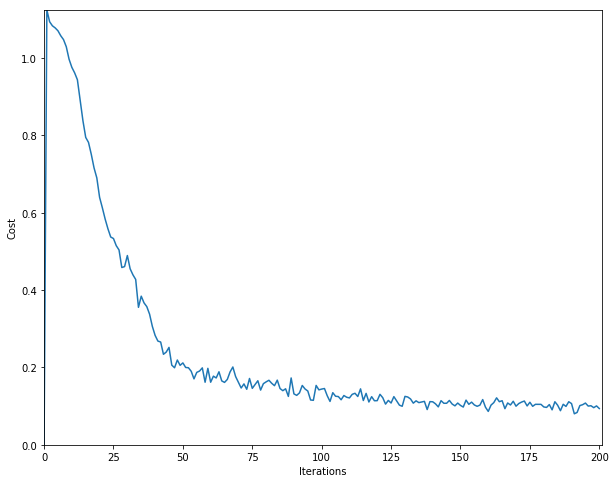

F-Score: 0.953
Accuracy:  0.9534550839091807
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      4433
          1       0.99      0.92      0.95     10016
          2       0.88      0.97      0.93      5811

avg / total       0.96      0.95      0.95     20260

[[4396    1   36]
 [  27 9264  725]
 [  29  125 5657]]


In [28]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations") 
plt.axis([0,len(cost_history),0,np.max(cost_history)])
plt.show()


p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
print("Accuracy: ", accuracy_score(y_true, y_pred))

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

In [29]:
'''
model_path_f = '../models/RNN/'
filename = 'my_RNN_model_S9_40.meta'


sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
loader = tf.train.import_meta_graph(model_path_f+filename)
loader.restore(sess, tf.train.latest_checkpoint(model_path_f))

SR = 22050
####
justone = True

while(justone):
    justone = False
    #print("start to record the audio.")
    
    frames = []
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    #print("Recording finished.")
    stream.stop_stream()
    stream.close()

    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    
    ####
    filename1 = '../data/phantom/JUNE_01_PHANTOMS/wavs/22050/WSU_P2_LOADED_BACK_AND_FORTH.wav'
    filename2 = '../data/phantom/JUNE_02_BACKGROUND/wavs/background/canopy_heavy_wind.wav'
    
    sample, sample_rate = librosa.load(filename1,SR)
    print(sample.shape)
    
    
    freqs, times, spectrogram = log_specgram(sample, sample_rate)    
    #showFreqTime([[sample, filename1, SR]])  

    spectrogram = (spectrogram - mean) / std
    
    dataX = spectrogram
    #print(dataX.shape)
    #print('delta shape:',dataX.shape)

    X_hot_list= []
    #print(dataX.shape[0] - seq_length+1)
    for i in range(0, dataX.shape[0] - seq_length+1):
        _x = dataX[i:i + seq_length]
        X_hot_list.append(_x)
    X_hot = np.array(X_hot_list[:])
    #print(X_hot[0])
    #print('\n\n\n')
    y_pred = sess.run(Y_pred,feed_dict={X: X_hot})
    #y_pred[y_pred<0.5] = 0
    #y_pred[y_pred>=0.5] = 1
    print(y_pred[20:30] )
    y_true = np.ones(shape=[y_pred.shape[0]])
    y_pred[y_pred<0.5] = 0
    y_pred[y_pred>=0.5] = 1
    
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print("F-Score:", round(f,3))
    print("Accuracy: ", accuracy_score(y_true, y_pred))

    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

    
    if y_pred[0] == 1:
        print('The sound is Drone')
    else :
        print('THe sound isn\'t Drone')
    

sess.close()
'''

'\nmodel_path_f = \'../models/RNN/\'\nfilename = \'my_RNN_model_S9_40.meta\'\n\n\nsess = tf.InteractiveSession()\nsess.run(tf.global_variables_initializer())\nloader = tf.train.import_meta_graph(model_path_f+filename)\nloader.restore(sess, tf.train.latest_checkpoint(model_path_f))\n\nSR = 22050\n####\njustone = True\n\nwhile(justone):\n    justone = False\n    #print("start to record the audio.")\n    \n    frames = []\n    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):\n        data = stream.read(CHUNK)\n        frames.append(data)\n    #print("Recording finished.")\n    stream.stop_stream()\n    stream.close()\n\n    p.terminate()\n\n    wf = wave.open(WAVE_OUTPUT_FILENAME, \'wb\')\n    wf.setnchannels(CHANNELS)\n    wf.setsampwidth(p.get_sample_size(FORMAT))\n    wf.setframerate(RATE)\n    wf.writeframes(b\'\'.join(frames))\n    wf.close()\n    \n    ####\n    filename1 = \'../data/phantom/JUNE_01_PHANTOMS/wavs/22050/WSU_P2_LOADED_BACK_AND_FORTH.wav\'\n    filename2 = \'../d